In [2]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb
import torch
import torch.nn as nn

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [5]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df): #Standardize the dtype.
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df): #Change the feature for D to the difference in days from date_decision.
        for col in df.columns:
            if (col[-1] in ("D",)) and ('count' not in col):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df): #Remove those with an average is_null exceeding 0.95 and those that do not fall within the range 1 < nunique < 200.
        for col in df.columns:

            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM", ]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 50):
                    df = df.drop(col)
                    
            if (col[-1] not in ["P", "A", "L", "M"]) and (('month_' in col) or ('year_' in col)):# or ('num_group' in col):
            # if (('month_' in col) or ('year_' in col)):# or ('num_group' in col):
                df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM", ]) & (df[col].dtype in[pl.Int64, pl.Float64]):
                std = df[col].std()
                if std == 0:
                    df = df.drop(col)

        return df


In [8]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]

        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_{col}") for col in cols]
        
        cols2 = [col for col in df.columns if col[-1] in ("L", "A")]
        expr_3 = [pl.mean(col).alias(f"mean_{col}") for col in cols2] + [pl.std(col).alias(f"std_{col}") for col in cols2] + \
            [pl.sum(col).alias(f"sum_{col}") for col in cols2] 
        
        return expr_1 + expr_2 + expr_3 
    
    @staticmethod
    def applprev2_exprs(df):
        cols = [col for col in df.columns if "num_group" not in col]
        expr_2 = [pl.first(col).alias(f"first_{col}") for col in cols]
        return []
    

    @staticmethod
    def bureau_a1(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_{col}") for col in cols]

        cols2 = [
        'annualeffectiverate_199L', 'annualeffectiverate_63L',
        'contractsum_5085717L', 
        'credlmt_230A', 'credlmt_935A',
       'nominalrate_281L', 'nominalrate_498L',
       'numberofcontrsvalue_258L', 'numberofcontrsvalue_358L',
       'numberofinstls_229L', 'numberofinstls_320L',
       'numberofoutstandinstls_520L', 'numberofoutstandinstls_59L',
       'numberofoverdueinstlmax_1039L', 'numberofoverdueinstlmax_1151L',
       'numberofoverdueinstls_725L', 'numberofoverdueinstls_834L'
       ]
        
        expr_3 = [pl.mean(col).alias(f"mean_{col}") for col in cols2] + [pl.std(col).alias(f"std_{col}") for col in cols2] + \
            [pl.sum(col).alias(f"sum_{col}") for col in cols2] +\
            [pl.first(col).alias(f"first_{col}") for col in cols2] 

        return expr_1 + expr_2 + expr_3    


    @staticmethod
    def bureau_b1(df):  
        return []
    
    
    @staticmethod
    def bureau_b2(df):
        
        return []


    @staticmethod
    def deposit_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] # + \
        return expr_1 

    @staticmethod
    def debitcard_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] 
        return expr_1


    @staticmethod
    def person_expr(df):
        cols1 = ['empl_employedtotal_800L', 'empl_employedfrom_271D', 'empl_industry_691L', 
                 'familystate_447L', 'incometype_1044T', 'sex_738L', 'housetype_905L', 'housingtype_772L',
                 'isreference_387L', 'birth_259D', ]
        expr_1 = [pl.first(col).alias(f"first_{col}") for col in cols1]
        
        expr_2 = [pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"), 
                  pl.col("mainoccupationinc_384A").filter(pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")]
        return expr_1 + expr_2 # + expr_4 # + expr_3
    
    @staticmethod
    def person_2_expr(df):
        cols = ['empls_economicalst_849M', 'empls_employedfrom_796D', 'empls_employer_name_740M'] # + \
        expr_1 = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_2 = [pl.last(col).alias(f"last_{col}") for col in cols]
        return expr_1 + expr_2

    @staticmethod
    def other_expr(df):
        expr_1 = [pl.first(col).alias(f"__other_{col}") for col in df.columns if ('num_group' not in col) and (col != 'case_id')]
        return expr_1 
    
    
    @staticmethod
    def tax_a_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] + \
            [pl.last(col).alias(f"last_{col}") for col in cols] + \
            [pl.first(col).alias(f"first_{col}") for col in cols] + \
            [pl.mean(col).alias(f"mean_{col}") for col in cols] + \
            [pl.std(col).alias(f"std_{col}") for col in cols]
        expr_4 = [pl.col(col).fill_null(strategy="zero").apply(lambda x: x.max() - x.min()).alias(f"max-min_gap_depth2_{col}") for col in ['amount_4527230A']]

        return expr_1 + expr_4


    @staticmethod
    def bureau_a2(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]

        expr_1 = [pl.max(col).alias(f"max_depth2_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_depth2_{col}") for col in cols]
        expr_3 = [pl.mean(col).alias(f"mean_depth2_{col}") for col in cols] + \
            [pl.std(col).alias(f"std_{col}") for col in cols]
        
        expr_4 = [pl.col(col).fill_null(strategy="zero").apply(lambda x: x.max() - x.min()).alias(f"max-min_gap_depth2_{col}") for col in ['collater_valueofguarantee_1124L', 'pmts_dpd_1073P', 'pmts_overdue_1140A',]]

        expr_ngc = [pl.count("num_group2").alias(f"count_depth2_a2_num_group2")]

        return expr_1 + expr_2 + expr_3 + expr_4 + expr_ngc
    
    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df)

        return exprs


In [9]:
def agg_by_case(path, df):
    path = str(path)
    if '_applprev_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
        
    elif '_credit_bureau_a_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.bureau_a1(df))

    elif '_credit_bureau_b_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.bureau_b1(df))

    elif '_deposit_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.deposit_exprs(df))
    elif '_debitcard_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.debitcard_exprs(df))
        
    elif '_tax_registry_a' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.tax_a_exprs(df))
    elif '_tax_registry_b' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
    elif '_tax_registry_c' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
        
    elif '_other_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.other_expr(df))
    elif '_person_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.person_expr(df))
    elif '_person_2' in path:
        df = df.group_by("case_id").agg(Aggregator.person_2_expr(df))

    elif '_credit_bureau_a_2' in path:
        df = df.group_by("case_id").agg(Aggregator.bureau_a2(df))
    elif '_credit_bureau_b_2' in path:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_file(path, depth=None): 
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = agg_by_case(path, df)
    
    print(f"{path}: {df.shape}")
    
    return df

def read_files(regex_path, depth=None):
    
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = agg_by_case(path, df)
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    print(f"{regex_path}: {df.shape}")
    
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base.with_columns(
            decision_month = pl.col("date_decision").dt.month(),
            decision_weekday = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    print(df_data.info())
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

def pd_to_polars(df):
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if pd.api.types.is_integer_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(int)
            elif pd.api.types.is_float_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(float)

    return pl.from_pandas(df)

In [10]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [11]:
data_store = {
     "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
     "depth_0": [
         read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
         read_files(TRAIN_DIR / "train_static_0_*.parquet"),
        
     ],
     "depth_1": [
         read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
         read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
         read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
         read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
         read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
         read_file(TRAIN_DIR / "train_person_1.parquet", 1),
         read_file(TRAIN_DIR / "train_other_1.parquet", 1),
     ],
     "depth_2": [
         read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
         read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
         read_file(TRAIN_DIR / "train_person_2.parquet", 2),
     ]
 }

/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet: (1526659, 5)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_static_cb_0.parquet: (1500476, 53)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_static_0_*.parquet: (1526659, 168)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_applprev_1_*.parquet: (1221522, 150)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_*.parquet: (1386273, 225)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_b_1.parquet: (36500, 1)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_deposit_1.parquet: (105111, 9)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_debitcard_1.parquet: (111772, 11)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train

In [12]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 774)


In [13]:
df_train = df_train.pipe(Pipeline.filter_cols)
print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 596)


In [14]:
del data_store
gc.collect()

44

In [10]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
    ],
    "depth_2": [
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2),
    ]
}

/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_*.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_1_*.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_*.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_2_*.parquet


In [11]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)

test data shape:	 (10, 773)


In [12]:
df_test.shape

(10, 773)

In [15]:
class Feature_Selector:
    @staticmethod
    def stats_generator(df):
        stats = pd.DataFrame(df.describe(include = 'all')).T.reset_index()
        stats = stats.rename(columns = {'index': 'columns'})
        stats.insert(1, 'dtype', list(stats['columns'].apply(lambda x: df[x].dtype)))
        stats['nunique'] = stats['columns'].apply(lambda x: df_train[x].nunique())
        stats['perc_null'] = 1 - stats['count']/stats['count'].max()
        stats = stats.drop(['unique', 'freq', 'top'], axis = 1)
        for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'perc_null']:
            stats[col] = pd.to_numeric(stats[col], errors = 'coerce')
        
        return stats
    
    @staticmethod
    def transform_category(df, cat_cols = None):
        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)
    
        df[cat_cols] = df[cat_cols].astype("category")
        cat_cols = df.select_dtypes("category").columns
        return df, cat_cols
    
    @staticmethod
    def cat_to_string(df, cat_cols = None):
        if cat_cols is None:
            cat_cols = list(df.select_dtypes("category").columns)
    
        df[cat_cols] = df[cat_cols].astype("object")
        cat_cols = df.select_dtypes("object").columns
        return df, cat_cols
    
    @staticmethod
    def mann_whitney_test(df, col, target, alpha = 0.05):
        """
        Checks if two samples (non-target vs target) come from the same distribution
        Checking dependence of a column to target variable
        Default alpha: 0.05
        """
        from scipy.stats import mannwhitneyu
        
        if df[col].dtypes not in ['int64', 'float64'] and col != target:
            return None
        
        sample1 = df[df[target] == 0][col]
        sample2 = df[df[target] == 1][col]
        
        statistic, p_value = mannwhitneyu(sample1, sample2)
        
        return p_value
        
    @staticmethod
    def chi_square(df, target_col, column):
        """
        Returns the chi-square p-value for each column in the DataFrame
        compared to the target column.

        Requires target and subject column to be categorical/binary

        """
        
        from scipy.stats import chi2_contingency
    
        if df[column].dtypes != 'category' or column == target_col or df[column].nunique() > 50:
            return None

        contingency = pd.crosstab(df[column], df[target_col])
        chi2, p_value, _, _ = chi2_contingency(contingency)

        return p_value
    
    @staticmethod
    def anova_f(df, target, col, impute = None):
        from sklearn.feature_selection import f_classif
        
        if df[col].dtypes not in ['int64', 'float64']:
            return None
        
        if col in ['case_id', 'target', 'WEEK_NUM', 'decision_month', 'decision_weekday']:
            return None
        
        df = df[[col, target]]
        
        if impute is None:
            df = df.dropna(subset=[col])
            if len(df[target].unique()) < 2:
                return None
        
        elif impute == 'mean':
            df[col] = df.fillna(df[col].mean())
        
        elif impute == 'median':
            df[col] = df.fillna(df[col].median())
            
        elif impute == 'zero':
            df[col] = df.fillna(0)
            
        elif impute.isnumeric():
            df[col] = df.fillna(eval(impute))
        
        f_statistic, p_val = f_classif(df[col].to_numpy().reshape(-1,1), df[target].to_numpy())
        return p_val[0]
    
    @staticmethod
    def pearson_corr(df, target, col):
        if target != col and df[col].dtype in ['int64', 'float64']:
            return df[target].corr(df[col])
        return None
    
    @staticmethod
    def num_cols(df, exclude):
        num_cols = [col for col, dtype in df.dtypes.items() if col not in exclude and dtype in ['int64', 'float64']]
        return num_cols
    
    @staticmethod
    def correl_del(df, stats, threshold = 0.9):
        stats['corr'] = stats['corr'].apply(lambda x: np.abs(x))
        stats = stats.sort_values(by = ['columns', 'corr', 'anova_dropna', 'perc_null', 'std'],
                                  ascending = [True, False, True, True, False])
        drop_cols = []
        
        for col in df.columns:
            if col not in drop_cols:
                cols = [x for x in df.columns if x != 'target']
                corr = df[cols].corrwith(df[col])
                high_corr = corr[np.abs(corr) > threshold].index
                if high_corr > 1:
                    drop = list(stats[stats['columns'].isin(high_corr)]['columns'][1:])
                    print(f"{col} -> Drop: {drop}")
                    drop_cols.append(drop)
            else:
                print(f"{col}: Dropped")
                               
        return drop_cols

In [16]:
def root_col(x):
    split = x.split('_')
    if split[0] in ['min', 'max', 'mean', 'var', 'mode', 'first', 'last', 'std', 'count']:
        return '_'.join(split[1:])
    return x

def dupe_col(df, x):
    return len(df[df == x])

### Feature Selection

In [17]:
df_train = df_train.to_pandas()

In [18]:
df_train, cat_cols = Feature_Selector.transform_category(df_train)

In [19]:
df_train.head()

,case_id,WEEK_NUM,target,decision_month,decision_weekday,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,std_pmts_overdue_1140A,std_pmts_overdue_1152A,max-min_gap_depth2_collater_valueofguarantee_1124L,max-min_gap_depth2_pmts_dpd_1073P,max-min_gap_depth2_pmts_overdue_1140A,count_depth2_a2_num_group2,first_empls_economicalst_849M,first_empls_employer_name_740M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
pd.DataFrame(df_train.dtypes).to_csv('data_schema.csv')

In [17]:
stats = Feature_Selector.stats_generator(df_train)
stats['chi_p'] = stats['columns'].apply(lambda x: Feature_Selector.chi_square(df_train, 'target', x))
stats['anova_dropna'] = stats['columns'].apply(lambda x: Feature_Selector.anova_f(df_train, 'target', x))
stats['corr'] = stats['columns'].apply(lambda x: Feature_Selector.pearson_corr(df_train, 'target', x))
stats

,columns,dtype,count,mean,std,min,25%,50%,75%,max,nunique,perc_null,chi_p,anova_dropna,corr
0,case_id,int64,1526659.0,1.286077e+06,718946.592285,0.0,766197.5,1357358.0,1739022.5,2703454.0,1526659,0.000000,NaN,NaN,0.003834
1,WEEK_NUM,int64,1526659.0,4.076904e+01,23.797981,0.0,23.0,40.0,55.0,91.0,92,0.000000,NaN,NaN,0.002969
2,target,int64,1526659.0,3.143728e-02,0.174496,0.0,0.0,0.0,0.0,1.0,2,0.000000,NaN,NaN,NaN
3,decision_month,int8,1526659.0,6.425584e+00,3.512803,1.0,3.0,7.0,9.0,12.0,12,0.000000,NaN,NaN,NaN
4,decision_weekday,int8,1526659.0,3.984014e+00,1.988480,1.0,2.0,4.0,6.0,7.0,7,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,count_depth2_a2_num_group2,float64,1385288.0,1.359273e+02,129.050030,1.0,48.0,96.0,180.0,9404.0,338,0.092602,NaN,1.314952e-207,-0.026120
592,first_empls_economicalst_849M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0.059970,0.005286,NaN,NaN
593,first_empls_employer_name_740M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.059970,1.000000,NaN,NaN
594,last_empls_economicalst_849M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0.059970,0.863548,NaN,NaN


In [18]:
stats.to_csv('stats.csv')

In [19]:
num_cols = Feature_Selector.num_cols(df_train, ['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'])
len(num_cols)

509

In [20]:
gc.collect()
stats['abs_corr'] = stats['corr'].apply(lambda x: np.abs(x))
stats = stats.sort_values(by = ['abs_corr', 'anova_dropna', 'perc_null', 'std'],
                                  ascending = [False, True, True, False])
drop_cols = []
        
for i, col in enumerate(num_cols):
    if col not in drop_cols:
        cols = [x for x in num_cols if x != 'target']
        corr = df_train[cols].corrwith(df_train[col])
        high_corr = corr[np.abs(corr) > 0.9].index
        #if len(high_corr) > 1:
        if len(high_corr) > 2:
            drop = list(stats[stats['columns'].isin(high_corr)]['columns'][2:])
            drop = [x for x in drop if x not in drop_cols]
            drop_cols.extend(drop)
            print(f"{i}: {col} -> Drop: {drop}, {len(drop_cols)} cols to drop")
        else:
            print(f"{i}: {col} -> No High Corr, {len(drop_cols)} cols to drop")
    else:
        print(f"{i}: {col} -> Already Dropped, {len(drop_cols)} cols to drop")

del cols
del corr
del high_corr
del drop
gc.collect()

0: assignmentdate_238D -> No High Corr, 0 cols to drop
1: assignmentdate_4527235D -> No High Corr, 0 cols to drop
2: birthdate_574D -> Drop: ['dateofbirth_337D'], 1 cols to drop
3: contractssum_5085716L -> Drop: ['max_contractsum_5085717L'], 2 cols to drop
4: dateofbirth_337D -> Already Dropped, 2 cols to drop
5: days120_123L -> Drop: ['days90_310L'], 3 cols to drop
6: days180_256L -> No High Corr, 3 cols to drop
7: days30_165L -> No High Corr, 3 cols to drop
8: days360_512L -> No High Corr, 3 cols to drop
9: days90_310L -> Already Dropped, 3 cols to drop
10: firstquarter_103L -> No High Corr, 3 cols to drop
11: fourthquarter_440L -> No High Corr, 3 cols to drop
12: numberofqueries_373L -> No High Corr, 3 cols to drop
13: pmtaverage_3A -> No High Corr, 3 cols to drop
14: pmtaverage_4527227A -> No High Corr, 3 cols to drop
15: pmtcount_4527229L -> No High Corr, 3 cols to drop
16: pmtcount_693L -> Drop: ['mean_num_group1', 'pmtscount_423L', 'std_num_group1', 'max_num_group1_9', 'pmtcount

0

In [28]:
import pickle
with open('drop_num_cols_top2.pkl', 'wb') as f:
    pickle.dump(drop_cols, f)

In [22]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 6085.83 MB
Memory usage after optimization is: 2205.77 MB
Decreased by 63.8%


In [23]:
keep_cols = [x for x in df_train.columns if x not in drop_cols]
len(keep_cols)

455

In [24]:
len(num_cols) - len(drop_cols)

368

0.00    0.000000
0.25    0.152682
0.50    0.296460
0.75    0.550644
1.00    0.948890
Name: perc_null, dtype: float64


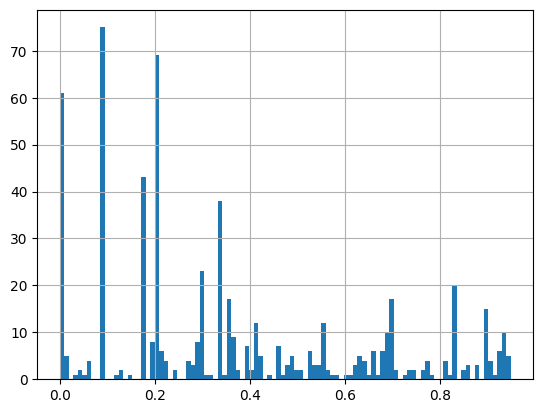

In [18]:
print(stats['perc_null'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats['perc_null'].hist(bins = 100);

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...
461,twobodfilling_608L,Type of application process.
462,type_25L,Contact type of a person.
463,typesuite_864L,Persons accompanying the client during the loa...


In [22]:
stats.to_csv('stats.csv')

0.00     1.0
0.25     3.0
0.50     5.0
0.75     9.0
1.00    45.0
Name: nunique, dtype: float64


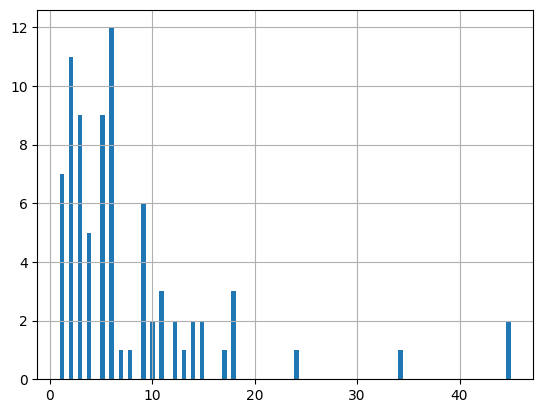

In [23]:
print(stats[stats['dtype'] == 'object']['nunique'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats[stats['dtype'] == 'object']['nunique'].hist(bins = 100);

0.00    0.000000e+00
0.25    6.154084e+00
0.50    4.500426e+02
0.75    1.719767e+04
1.00    3.916514e+08
Name: std, dtype: float64


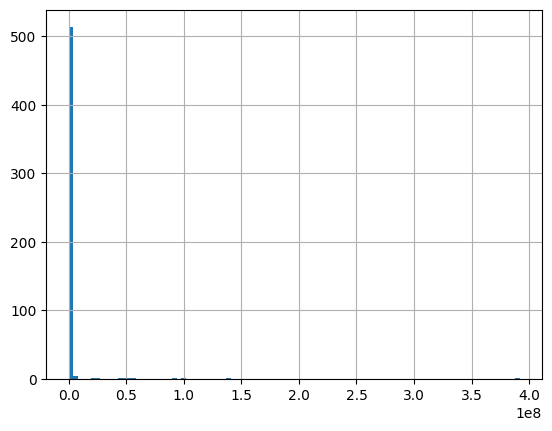

In [24]:
print(stats[stats['dtype'] != 'object']['std'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats[stats['dtype'] != 'object']['std'].hist(bins = 100);

In [24]:
stats = stats[~((stats['dtype'] != 'object') & (stats['std']==0))]
stats.head(20)

,columns,dtype,count,mean,std,min,25%,50%,75%,max,nunique,perc_null,root_col,Variable,Description
0,case_id,int64,1526659.0,1.286077e+06,718946.592285,0.0,766197.50,1357358.0,1739022.50,2703454.00,1526659,0.000000,case_id,NaN,NaN
1,WEEK_NUM,int64,1526659.0,4.076904e+01,23.797981,0.0,23.00,40.0,55.00,91.00,92,0.000000,WEEK_NUM,NaN,NaN
2,target,int64,1526659.0,3.143728e-02,0.174496,0.0,0.00,0.0,0.00,1.00,2,0.000000,target,NaN,NaN
3,decision_month,int8,1526659.0,6.425584e+00,3.512803,1.0,3.00,7.0,9.00,12.00,12,0.000000,decision_month,NaN,NaN
4,decision_weekday,int8,1526659.0,3.984014e+00,1.988480,1.0,2.00,4.0,6.00,7.00,7,0.000000,decision_weekday,NaN,NaN
5,assignmentdate_238D,float64,136996.0,-2.368489e+03,2316.350761,-16454.0,-3409.00,-1850.0,-610.00,14.00,9387,0.910264,assignmentdate_238D,assignmentdate_238D,Tax authority data - date of assignment.
6,assignmentdate_4527235D,float64,114978.0,1.394515e+01,0.410493,7.0,14.00,14.0,14.00,14.00,8,0.924687,assignmentdate_4527235D,assignmentdate_4527235D,Tax authority data - Date of assignment.
7,birthdate_574D,float64,607871.0,-1.606577e+04,5108.123925,-27774.0,-20251.00,-15434.0,-11720.00,-7656.00,19877,0.601829,birthdate_574D,birthdate_574D,Client's date of birth (credit bureau data).
8,contractssum_5085716L,float64,157329.0,6.416044e+05,980327.297131,0.0,78531.95,307282.4,802114.08,31296759.11,136290,0.896946,contractssum_5085716L,contractssum_5085716L,Total sum of values of contracts retrieved fro...
9,dateofbirth_337D,float64,1385691.0,-1.628238e+04,5054.532403,-44073.0,-20417.00,-15630.0,-12033.00,-58.00,20081,0.092338,dateofbirth_337D,dateofbirth_337D,Client's date of birth.


0.00    0.000000
0.25    0.172044
0.50    0.296460
0.75    0.540480
1.00    0.948890
Name: perc_null, dtype: float64


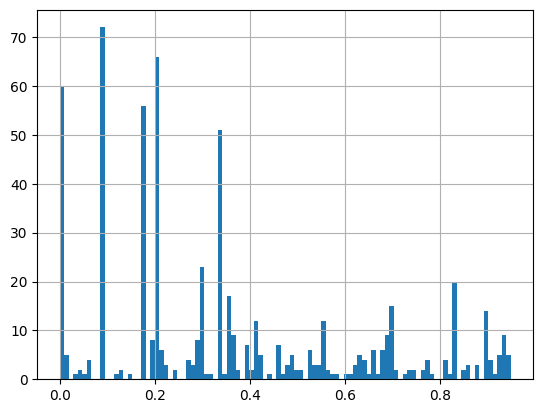

In [25]:
print(stats['perc_null'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats['perc_null'].hist(bins = 100);

In [27]:
df_train = df_train[list(stats['columns'])]

In [28]:
id_cols = ['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday']
feature_cols = [x for x in stats['columns'] if x not in id_cols]
num_cols = [x for x in stats[stats['dtype']!='object']['columns'] if x not in id_cols]

In [31]:
num_col_red1 = correlation_based_deletion(df_train[num_cols[:200]])
num_col_red2 = correlation_based_deletion(df_train[num_cols[200:401]])
num_col_red3 = correlation_based_deletion(df_train[num_cols[401:]])
drop_cols_comb = correlation_based_deletion(df_train[keep_cols])

In [52]:
drop_cols = num_col_red1 + num_col_red2 + num_col_red3 + drop_cols_comb
keep_cols = [x for x in num_cols if x not in drop_cols]
len(keep_cols)

313

In [53]:
import pickle
with open('drop_cols.pkl', 'wb') as f:
    pickle.dump(drop_cols, f)

In [71]:
df_train = df_train.merge(target[['case_id', 'target']], on = 'case_id', how = 'left')

In [81]:
pl.from_pandas(df_train).write_csv('model_abt_pl_623.csv')

In [82]:
pl.from_pandas(df_train).write_csv('model_abt_pl_623.csv')

8

In [25]:
keep_cols = [x for x in df_train.columns if x not in drop_cols]

In [26]:
df_train,cat_cols = Feature_Selector.cat_to_string(df_train)

In [27]:
pl.from_pandas(df_train[keep_cols]).write_csv('model_abt_pl_corr2_drop.csv')

In [71]:
stats[stats['columns'].isin(drop_cols)].describe()

,mean,std,min,25%,50%,75%,max,nunique,perc_null,chi_p,anova_dropna,corr,abs_corr
count,2.270000e+02,2.270000e+02,2.270000e+02,2.270000e+02,2.270000e+02,2.270000e+02,2.270000e+02,2.270000e+02,227.000000,0.0,2.270000e+02,227.000000,227.000000
mean,6.680582e+06,2.481095e+06,4.682660e+06,6.543919e+06,6.706430e+06,6.892543e+06,1.695612e+09,9.366988e+04,0.405820,NaN,5.632002e-02,0.003535,0.024156
std,7.039084e+07,1.426355e+07,5.061909e+07,6.954648e+07,7.122954e+07,7.309325e+07,1.166484e+10,1.994118e+05,0.266956,NaN,1.841445e-01,0.030942,0.019592
min,-1.628238e+04,9.714489e-02,-7.588198e+06,-2.041700e+04,-1.563000e+04,-1.203300e+04,-7.656000e+03,3.000000e+00,0.000000,NaN,0.000000e+00,-0.059727,0.000110
25%,2.057931e+00,2.222210e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520000e+02,3.095000e+02,0.194590,NaN,4.519537e-208,-0.018354,0.007111
50%,2.304816e+01,6.124854e+02,0.000000e+00,0.000000e+00,4.005000e-01,9.000000e+00,4.808000e+03,5.178000e+03,0.335799,NaN,4.394076e-84,0.002385,0.021197
75%,2.790852e+03,1.865017e+04,0.000000e+00,8.000000e+00,1.950000e+01,1.000000e+03,6.380827e+05,7.660250e+04,0.633337,NaN,1.559543e-08,0.022783,0.035805
max,7.531677e+08,1.386306e+08,5.403423e+08,7.426119e+08,7.605763e+08,7.805201e+08,9.878000e+10,1.053260e+06,0.946341,NaN,9.715608e-01,0.119374,0.119374


In [66]:
pd_to_polars(df_train.drop(drop_cols, axis = 1)).write_csv('model_abt_pl_corr_drop.csv')

In [95]:
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

def model_evals(y_true, y_proba, cutoff = 0.5):
    """
    Returns model evaluation metrics for a binary classification model

    Parameters:
    -----------
        y_true: int (0,1) 
            Actual binary labels

        y_proba: float (between 0 and 1)
            Probability scores output of model 
        
    Returns:
    --------
        result: dict
            Dictionary of metrics and their results based on the input
                - event rate (% predicted 1's)
                - accuracy
                - roc_auc
                - pr_auc
                - recall
                - precision
                - f1
                - lift
    """

    y_pred = (y_proba > cutoff).astype(int)

    event_rate = y_pred.mean()

    accuracy = accuracy_score(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_proba)

    pr_auc = average_precision_score(y_true, y_proba)

    recall = recall_score(y_true, y_pred)

    precision = precision_score(y_true, y_pred)

    f1 = f1_score(y_true, y_pred)

    lift = recall / event_rate

    return {'event_rate': event_rate,
            'acc': accuracy, 
            'roc_auc': roc_auc,
            'pr_auc': pr_auc, 
            'recall': recall, 
            'precision': precision, 
            'f1': f1, 
            'lift': lift}



def lightgbm_df(df, target_col, feature_cols, split = 0.2, model_params = None):

    cat_cols = [col for col, dtype in dict(df_train[feature_cols].dtypes).items() if dtype == 'O']
    df[cat_cols] = df[cat_cols].astype('category')
    
    train_ind, test_ind = train_test_split(df.index, test_size=0.2, random_state=42)
    model = lightgbm.LGBMClassifier(**model_params)
    model.fit(df[feature_cols].iloc[train_ind], df[target_col].iloc[train_ind])
    
    y_proba = model.predict_proba(df[feature_cols].iloc[test_ind])[:, 1]
    results = model_evals(df[target_col].iloc[test_ind], y_test_proba)
    print(f'LigthGBM, Test Results: {results}" ')

In [ ]:
lightgbm_df(df_train, ['target'], [x for x in df_train.columns if x not in id_cols], split = 0.2, model_params = {'random_state': 42})

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastrejectcommoditycat_161M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_credacc_status_367L',
 'max_credtype_587L',
 'max_education_1138M',
 'max_familystate_726L',
 'max_inittransactioncode_279L',
 'max_isbidproduct_390L',
 'max_isdebitcard_527L',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'max_status_219L',
 'min_credacc_status_367L',
 'min_credtype_587L',
 'min_education_1138M',
 'min_familystate_726L',
 'min_inittransactioncode_279L',
 'min_isbidproduct_390L',
 'min_isdebitcard_527L',
 